<a href="https://colab.research.google.com/github/MartinBruchon/MartinBruchon/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm dataset.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip -q dataset.zipA

replace dataset/test/images/WIN_20230523_10_16_46_Pro.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
train_dir = "dataset/train"
test_dir = "dataset/test"

batch_size = 64
image_size = (512, 512)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input'
)

Found 32 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:
input_shape = (512, 512, 3)
model = build_unet(input_shape)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 50
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)
model.evaluate(test_generator)
model.save('tumor_model.h5')

Epoch 1/50
16/16 [==============================] - 47s 567ms/step - loss: 0.5459 - accuracy: 0.4391 - val_loss: 8.3671 - val_accuracy: 0.4997
Epoch 2/50
16/16 [==============================] - 8s 493ms/step - loss: 0.4108 - accuracy: 0.4999 - val_loss: 10.1503 - val_accuracy: 0.4991
Epoch 3/50
16/16 [==============================] - 8s 496ms/step - loss: 0.3850 - accuracy: 0.5001 - val_loss: 0.5929 - val_accuracy: 0.4999
Epoch 4/50
16/16 [==============================] - 8s 500ms/step - loss: 0.3641 - accuracy: 0.5002 - val_loss: 0.5978 - val_accuracy: 0.4998
Epoch 5/50
16/16 [==============================] - 8s 507ms/step - loss: 0.3514 - accuracy: 0.5002 - val_loss: 0.5329 - val_accuracy: 0.4998
Epoch 6/50
16/16 [==============================] - 8s 525ms/step - loss: 0.3435 - accuracy: 0.5002 - val_loss: 0.5477 - val_accuracy: 0.4998
Epoch 7/50
16/16 [==============================] - 8s 512ms/step - loss: 0.3552 - accuracy: 0.5002 - val_loss: 0.5807 - val_accuracy: 0.4998
Epoc

KeyboardInterrupt: ignored

In [ ]:
# import cv2
# import numpy as np

# def segment_defects(image_path, model):
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, image_size)
#     image = image / 255.0
#     image = np.expand_dims(image, axis=0)

#     mask = model.predict(image)[0]
#     mask = np.round(mask)  # Conversion en valeurs binaires

#     return mask

In [ ]:
# image_path = "path/to/image.jpg"
# mask = segment_defects(image_path, model)
# cv2.imshow("Defect Mask", mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def segment_defects(image_path, model):
    image = Image.open(image_path)
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    mask = model.predict(image)[0]
    mask = np.round(mask)  # Conversion en valeurs binaires

    return mask

1/1 [==============================] - 0s 23ms/step


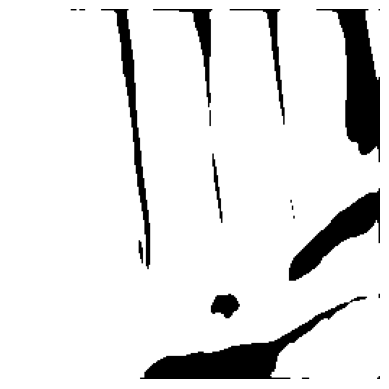

In [ ]:
image_path = "/content/dataset/train/images/09aefeec-e05f-11e8-87a6-0242ac1c0002.jpg"
mask = segment_defects(image_path, model)

plt.imshow(mask.squeeze(), cmap='gray')
plt.axis('off')
plt.show()